# Tarea 5: Programación Genética, Neutralidad y Bloating.

Estudiante: Rodrigo S. Cortez Madrigal

La Teoría Neutral de la Evolución Molecular propuesta por Motoo Kimura, sostiene que muchas mutaciones en el ADN son neutras, es decir, no tiene un efecto significativo que afecten la aptitud del organismo.

En Programación Genética, esto se traduce en la idea de que ciertos cambios en la estructura del árbol no cambian el resultado observable del programa. Es decir, hay individuos (programas) con diferente estructura genética (genotipo) que, sin embargo, producen el mismo valor de aptitud (es decir, tienen el mismo desempeño en la tarea a resolver). Esto implica que ciertas modificaciones genéticas (como mutaciones o cruces) no alteran el comportamiento funcional del programa, y por tanto no afectan su evaluación.

En biología, la neutralidad puede manifestarse de varias maneras, y en PG podemos observar fenómenos similares. Algunas de las manifestaciones más comunes incluyen los intrones.

Son partes del programa que nunca se ejecutan (inactivo) o que no influyen en la salida. 

Por ejemplo:

- (if (2 = 1) ... x) → la rama del if nunca se ejecuta.
- (+ x (- x x)) → el término (- x x) siempre es cero y no afecta el resultado.

Estos fragmentos pueden crecer sin afectar la aptitud, contribuyendo al fenómeno conocido como hinchamiento (bloat).

## Objetivo

Analizar empíricamente el fenómeno de bloat y neutralidad en algoritmos de Programación Genética, bajo dos configuraciones.

#### Lineamientos metodológicos:

- Ejecución completa: correr siempre hasta maxGen (no emplear paro temprano por convergencia).
- Diversidad sin restricciones: no utilizar elitismo ni penalizaciones que limiten la diversidad en la generación de individuos.
- Repeticiones: realizar 10 corridas independientes por experimento (use semillas distintas).
- Evaluación: defina explícitamente la métrica de aptitud (por ejemplo, error absoluto ∣f(x)−10∣).
Control de tamaño: respete nodosMax como restricción.

#### Resultados y visualizaciones requeridas:

- Dinámica de terminales: graficar, por generación, el conteo de 0, 1 y 4 en la población (promedio sobre las 10 corridas).
- Bloat: graficar el tamaño promedio de los árboles por generación para evidenciar crecimiento estructural.
- Comparación entre configuraciones: presentar en una figura o tabla la comparación de métricas clave (tamaño promedio, mejor aptitud final, tasa de soluciones exactas) entre {+} y {+, *}.

#### Entregables:

- Planteamiento y definiciones operativas.
- Descripción de parámetros y operadores (incluya semillas).
- Resultados con las gráficas solicitadas y discusión crítica.
- Conclusiones y limitaciones.

In [1]:
import deap
import math
import operator
import random
import functools
import numpy as np
import pandas as pd
from deap import gp, base, creator, tools, algorithms
import plotly.graph_objs as go

# Plotly render svgs
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
# Fitness function

def target_function():
    """Valor objetivo constante: 10"""
    return 10


## Experimento 1

- Funciones: {+}
- Terminales: {0, 1, 4}
- Prob. de cruza: 0.9
- Prob. de mutación nodo: 0.01 
- Tamaño de población: 100
- Generaciones máximas: 1000
- Tamaño máximo de árbol: 120
- Objetivo: Inducir una expresión que sume 10.

In [ ]:
POP_SIZE = 100 # tamaño de la población
N_GEN = 1000 # número de generaciones
CXPB = 0.9   # probabilidad de cruzamiento
MUTPB = 0.01  # probabilidad de mutación
MAX_TREE_SIZE = 120 # tamaño máximo del árbol
RANDOM_SEEDS = [42, 56, 78, 91, 13, 27, 34, 65, 89, 100]

In [4]:
# Primitivas y terminales

# Definición del conjunto de primitivas y terminales
pset = gp.PrimitiveSet('EXP1', 0)  # 0 argumentos de entrada

# Funciones
pset.addPrimitive(operator.add, 2)  # Suma

# Terminales constantes
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(4)

# Fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar el error
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3) # Generar árboles completos
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) # Crear individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individual) # Crear población
toolbox.register("compile", gp.compile, pset=pset) # Compilar árboles a funciones

# Evaluación


def fitness_function(individual, pset):
    """Compila el individuo (árbol GP) y calcula la aptitud como una tupla
    con el error absoluto |f(x) - 10|.

    Se maneja cualquier excepción devolviendo una aptitud muy alta (peor).
    """
    # Compila el árbol en una función ejecutable usando el primitive set
    func = gp.compile(expr=individual, pset=pset)
    if callable(func):
        try:
            value = func()
        except Exception:
            return (float('inf'),)
    else:
        value = func

    # Asegurar que el resultado sea numérico
    try:
        err = abs(float(value) - target_function())
    except Exception:
        return (float('inf'),)

    # DEAP espera una tupla como valor de fitness
    return (err,)

toolbox.register("evaluate", fitness_function, pset=pset)

# Operadores genéticos

toolbox.register("mate", gp.cxOnePoint)  # Cruzamiento de un punto
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2) # Mutación
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset) # Mutación uniforme
toolbox.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

# Control de tamaño
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=MAX_TREE_SIZE))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=MAX_TREE_SIZE))

# Estadísticas y registro del mejor
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("min", min)
stats.register("avg", np.mean)
stats.register("std", np.std)
hof = tools.HallOfFame(1)


In [5]:
# Veamos algunos individuos iniciales

pop = toolbox.population(n=POP_SIZE) # Población inicial

for i, ind in enumerate(pop[:5]):  # Muestra los primeros 5 árboles
    print(f"Árbol {i}:")
    print("Expresión:", str(ind))
    try:
        val = toolbox.compile(expr=ind)
        print("Valor evaluado:", val)
    except Exception as e:
        print("Error al evaluar:", e)
    print("-" * 40)

Árbol 0:
Expresión: add(0, 4)
Valor evaluado: 4
----------------------------------------
Árbol 1:
Expresión: add(add(add(0, 4), add(1, 4)), add(add(0, 4), add(4, 4)))
Valor evaluado: 21
----------------------------------------
Árbol 2:
Expresión: add(add(0, 0), add(0, 0))
Valor evaluado: 0
----------------------------------------
Árbol 3:
Expresión: add(0, 4)
Valor evaluado: 4
----------------------------------------
Árbol 4:
Expresión: add(4, 1)
Valor evaluado: 5
----------------------------------------


In [ ]:
# Tomado de deap.algorithms.eaSimple pero retornando todas las poblaciones

def custom_eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=True):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    populations = []

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        populations.append([ind.copy() for ind in population])

    return populations, logbook

### Corrida del experimento 1

In [7]:
# Corremos múltiples semillas y guardamos las poblaciones

logs = []
all_pops = {}  # all_pops[seed][gen]

for seed in RANDOM_SEEDS:
    random.seed(seed)
    pop = toolbox.population(n=POP_SIZE)

    pops, log = custom_eaSimple(
        pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,
        stats=stats, halloffame=hof, verbose=False,
    )
    log = pd.DataFrame(log)
    logs.append(log)
    all_pops[seed] = pops

In [8]:
len(all_pops[42]) # Confirma que hay 1000 generaciones guardadas

1000

In [9]:
# Graficar, por generación, el conteo de 0, 1 y 4 en la población (promedio sobre las 10 corridas)
# Calcular el tamaño promedio de los árboles por generación y su promedio sobre las corridas

counts = [] # Para guardar el conteo por generación de 0, 1 y 4 para cada
avg_tree_sizes = []  # Para guardar el tamaño promedio de árboles por generación para cada corrida

for seed in RANDOM_SEEDS:
    gen_counts = {'0': [], '1': [], '4': []}
    gen_tree_sizes = []
    for gen in range(N_GEN):
        pop = all_pops[seed][gen]
        count_0 = sum(str(ind).count('0') for ind in pop)
        count_1 = sum(str(ind).count('1') for ind in pop)
        count_4 = sum(str(ind).count('4') for ind in pop)
        gen_counts['0'].append(count_0)
        gen_counts['1'].append(count_1)
        gen_counts['4'].append(count_4)
        # Tamaño promedio de árboles en esta generación
        avg_size = np.mean([len(ind) for ind in pop])
        gen_tree_sizes.append(avg_size)
    counts.append(gen_counts)
    avg_tree_sizes.append(gen_tree_sizes)

# Ahora counts tiene, para cada semilla, el conteo por generación de 0, 1 y 4
# avg_tree_sizes tiene, para cada semilla, el tamaño promedio de árboles por generación

avg_counts = {'0': [], '1': [], '4': []}
avg_tree_size_per_gen = []
for gen in range(N_GEN):
    # Promedio del conteo de terminales en esta generación sobre todas las corridas
    avg_0 = np.mean([counts[seed_idx]['0'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_1 = np.mean([counts[seed_idx]['1'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_4 = np.mean([counts[seed_idx]['4'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_counts['0'].append(avg_0)
    avg_counts['1'].append(avg_1)
    avg_counts['4'].append(avg_4)
    # Promedio del tamaño de árbol en esta generación sobre todas las corridas
    avg_tree_size = np.mean([avg_tree_sizes[seed_idx][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_tree_size_per_gen.append(avg_tree_size)

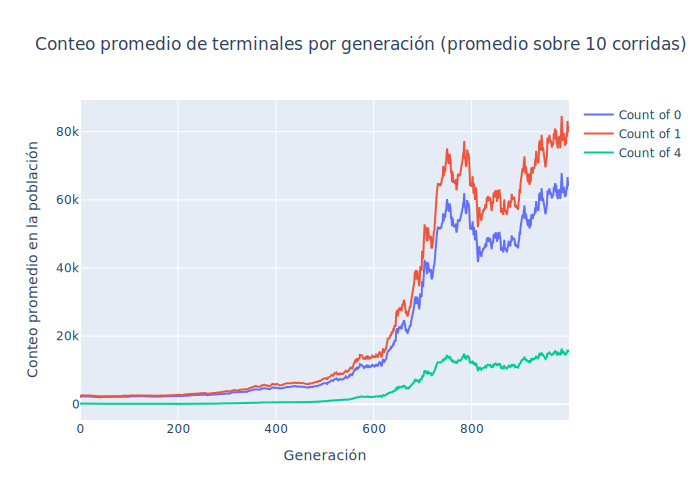

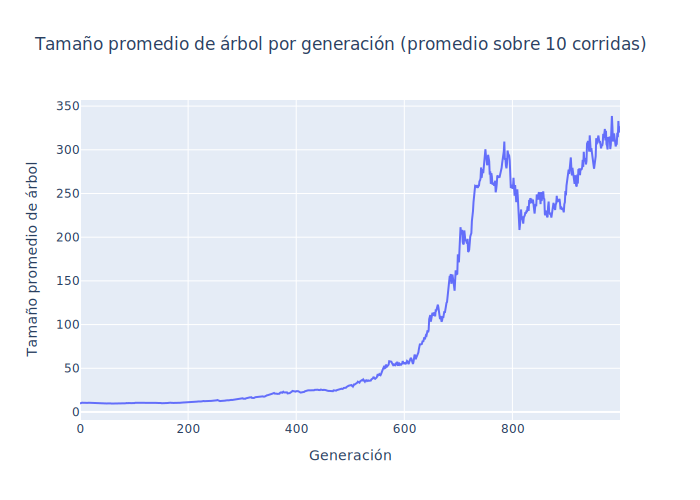

In [10]:
# Graficar el conteo promedio de terminales por generación para todas las corridas
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts['0'], mode='lines', name='Count of 0'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts['1'], mode='lines', name='Count of 1'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts['4'], mode='lines', name='Count of 4')) 
fig.update_layout(title='Conteo promedio de terminales por generación (promedio sobre 10 corridas)',
                  xaxis_title='Generación',
                  yaxis_title='Conteo promedio en la población')
fig.show()

# Promedio del tamaño del árbol por generación para todas las corridas
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_tree_size_per_gen, mode='lines', name='Tamaño promedio de árbol'))
fig2.update_layout(title='Tamaño promedio de árbol por generación (promedio sobre 10 corridas)',
                   xaxis_title='Generación',
                   yaxis_title='Tamaño promedio de árbol')
fig2.show()

## Experimento 2

Mismo objetivo y parámetros que el Experimento 1, modificando:
- Funciones: {+, *} 
- Prob. de mutación de rama : 0.1

In [11]:
POP_SIZE = 100
N_GEN = 1000
CXPB = 0.9   # probabilidad de cruzamiento
MUTPB = 0.1  # probabilidad de mutación
MAX_TREE_SIZE = 120
RANDOM_SEEDS = [42, 56, 78, 91, 13, 27, 34, 65, 89, 100]

In [ ]:
# Primitivas y terminales

# Definición del conjunto de primitivas y terminales
pset2 = gp.PrimitiveSet('EXP1', 0)  # 0 argumentos de entrada

# Funciones
pset2.addPrimitive(operator.add, 2)  # Suma
pset2.addPrimitive(operator.mul, 2)  # Multiplicación

# Terminales constantes
pset2.addTerminal(0)
pset2.addTerminal(1)
pset2.addTerminal(4)

# Fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar el error
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# Toolbox
toolbox2 = base.Toolbox()
toolbox2.register("expr", gp.genFull, pset=pset2, min_=1, max_=3) # Generar árboles completos
toolbox2.register("individual", tools.initIterate, creator.Individual, toolbox2.expr) # Crear individuos
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual) # Crear población
toolbox2.register("compile", gp.compile, pset=pset2) # Compilar árboles a funciones

# Evaluación
toolbox2.register("evaluate", fitness_function, pset=pset2)

# Operadores genéticos

toolbox2.register("mate", gp.cxOnePoint)  # Cruzamiento de un punto
toolbox2.register("expr_mut", gp.genFull, min_=0, max_=2) # Mutación
toolbox2.register("mutate", gp.mutUniform, expr=toolbox2.expr_mut, pset=pset2) # Mutación uniforme
toolbox2.register("select", tools.selTournament, tournsize=3)  # Selección por torneo

# Control de tamaño
toolbox2.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=MAX_TREE_SIZE))
toolbox2.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=MAX_TREE_SIZE))

# Estadísticas y registro del mejor
stats2 = tools.Statistics(lambda ind: ind.fitness.values[0])
stats2.register("min", min)
stats2.register("avg", np.mean)
stats2.register("std", np.std)
hof2 = tools.HallOfFame(1)


In [13]:
# Corremos múltiples semillas y guardamos las poblaciones

logs2 = []
all_pops2 = {}  # all_pops[seed][gen]

for seed in RANDOM_SEEDS:
    random.seed(seed)
    pop = toolbox.population(n=POP_SIZE)

    pops, log = custom_eaSimple(
        pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,
        stats=stats, halloffame=hof, verbose=False,
    )
    log = pd.DataFrame(log)
    logs2.append(log)
    all_pops2[seed] = pops

In [14]:
# Graficar, por generación, el conteo de 0, 1 y 4 en la población (promedio sobre las 10 corridas)
# Calcular el tamaño promedio de los árboles por generación y su promedio sobre las corridas

counts2 = [] # Para guardar el conteo por generación de 0, 1 y 4 para cada
avg_tree_sizes2 = []  # Para guardar el tamaño promedio de árboles por generación para cada corrida

for seed in RANDOM_SEEDS:
    gen_counts2 = {'0': [], '1': [], '4': []}
    gen_tree_sizes2 = []
    for gen in range(N_GEN):
        pop = all_pops2[seed][gen]
        count_0 = sum(str(ind).count('0') for ind in pop)
        count_1 = sum(str(ind).count('1') for ind in pop)
        count_4 = sum(str(ind).count('4') for ind in pop)
        gen_counts2['0'].append(count_0)
        gen_counts2['1'].append(count_1)
        gen_counts2['4'].append(count_4)
        # Tamaño promedio de árboles en esta generación
        avg_size2 = np.mean([len(ind) for ind in pop])
        gen_tree_sizes2.append(avg_size2)
    counts2.append(gen_counts)
    avg_tree_sizes2.append(gen_tree_sizes)

# Ahora counts tiene, para cada semilla, el conteo por generación de 0, 1 y 4
# avg_tree_sizes tiene, para cada semilla, el tamaño promedio de árboles por generación

avg_counts2 = {'0': [], '1': [], '4': []}
avg_tree_size_per_gen2 = []
for gen in range(N_GEN):
    # Promedio del conteo de terminales en esta generación sobre todas las corridas
    avg_0 = np.mean([counts2[seed_idx]['0'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_1 = np.mean([counts2[seed_idx]['1'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_4 = np.mean([counts2[seed_idx]['4'][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_counts2['0'].append(avg_0)
    avg_counts2['1'].append(avg_1)
    avg_counts2['4'].append(avg_4)
    # Promedio del tamaño de árbol en esta generación sobre todas las corridas
    avg_tree_size2 = np.mean([avg_tree_sizes2[seed_idx][gen] for seed_idx in range(len(RANDOM_SEEDS))])
    avg_tree_size_per_gen2.append(avg_tree_size2)

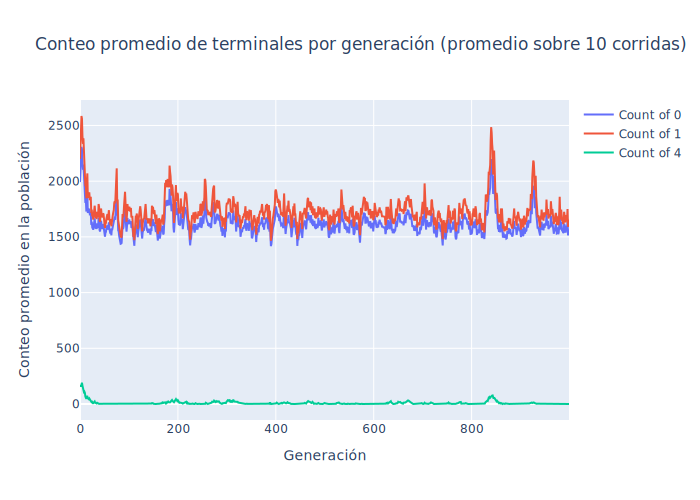

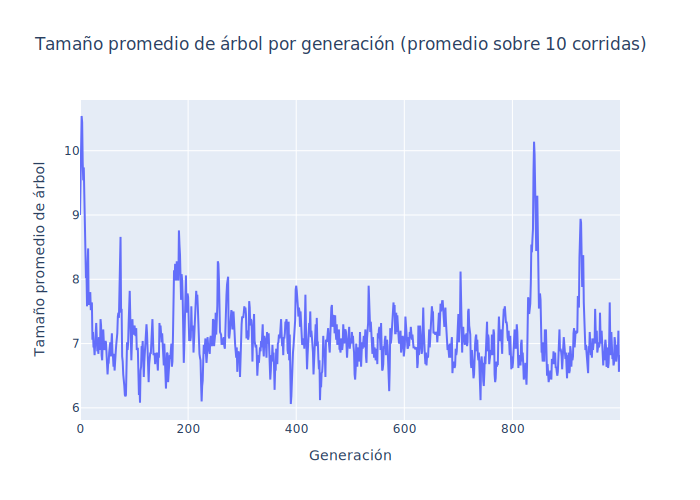

In [15]:
# Graficar el conteo promedio de terminales por generación para todas las corridas
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts2['0'], mode='lines', name='Count of 0'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts2['1'], mode='lines', name='Count of 1'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_counts2['4'], mode='lines', name='Count of 4')) 
fig.update_layout(title='Conteo promedio de terminales por generación (promedio sobre 10 corridas)',
                  xaxis_title='Generación',
                  yaxis_title='Conteo promedio en la población')
fig.show()

# Promedio del tamaño del árbol por generación para todas las corridas
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_tree_size_per_gen2, mode='lines', name='Tamaño promedio de árbol'))
fig2.update_layout(title='Tamaño promedio de árbol por generación (promedio sobre 10 corridas)',
                   xaxis_title='Generación',
                   yaxis_title='Tamaño promedio de árbol')
fig2.show()

## Comparación de resultados entre Experimento 1 y Experimento 2

Comparación entre configuraciones: presentar en una figura o tabla la comparación de métricas clave (tamaño promedio, mejor aptitud final, tasa de soluciones exactas) entre {+} y {+, *}.

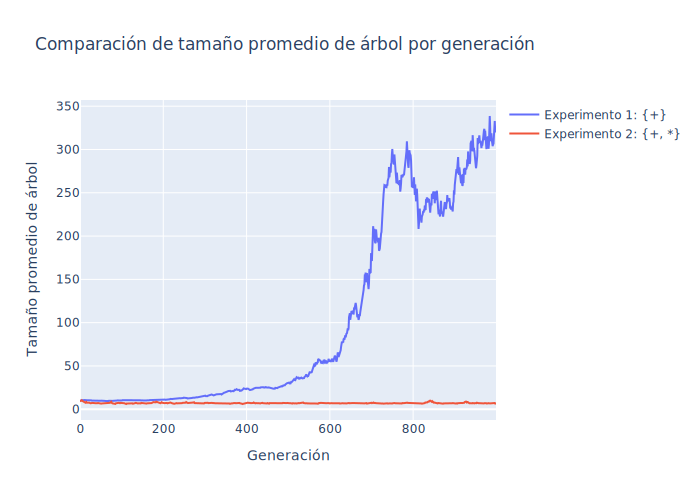

In [16]:
# Comparacion de tamaños de árboles entre Experimento 1 y Experimento 2

# Para eso vamos a reutilizar avg_tree_size_per_gen y avg_tree_size_per_gen2

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_tree_size_per_gen, mode='lines', name='Experimento 1: {+}'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_tree_size_per_gen2, mode='lines', name='Experimento 2: {+, *}'))
fig.update_layout(title='Comparación de tamaño promedio de árbol por generación',
                   xaxis_title='Generación',
                   yaxis_title='Tamaño promedio de árbol')
fig.show()

In [20]:
# Comparemos ahora la taza de soluciones exactas (fitness 0) entre los dos experimentos
# Para eso contamos, por generación y por corrida, cuántos individuos tienen fitness 0

def count_exact_solutions(all_pops, toolbox, ngen, seeds):
    exact_counts = []  # exact_counts[run][gen]
    for seed in seeds:
        run_counts = []
        for gen in range(ngen):
            pop = all_pops[seed][gen]
            count_exact = sum(
                1 for ind in pop
                if toolbox.evaluate(gp.PrimitiveTree(ind))[0] == 0
            )
            run_counts.append(count_exact)
        exact_counts.append(run_counts)
    return exact_counts

# Experimento 1
exact_counts1 = count_exact_solutions(all_pops, toolbox, N_GEN, RANDOM_SEEDS)
# Experimento 2
exact_counts2 = count_exact_solutions(all_pops2, toolbox2, N_GEN, RANDOM_SEEDS)


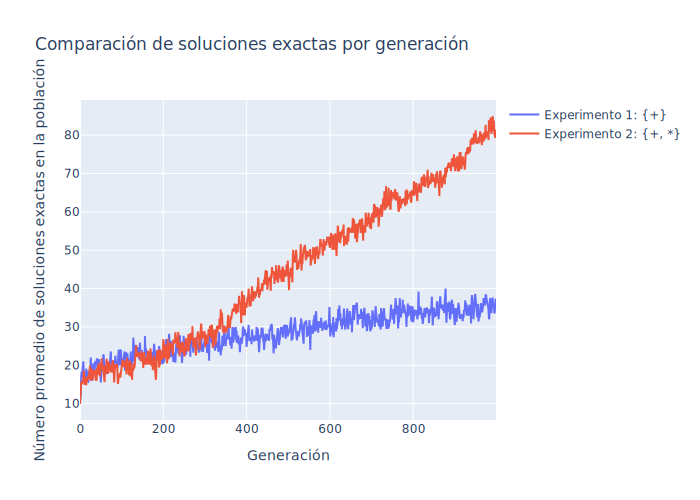

In [21]:
# Graficar la taza de soluciones exactas por generación para ambos experimentos
avg_exact1 = np.mean(exact_counts1, axis=0)
avg_exact2 = np.mean(exact_counts2, axis=0)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_exact1, mode='lines', name='Experimento 1: {+}'))
fig.add_trace(go.Scatter(x=list(range(N_GEN)), y=avg_exact2, mode='lines', name='Experimento 2: {+, *}'))
fig.update_layout(title='Comparación de soluciones exactas por generación',
                   xaxis_title='Generación',
                   yaxis_title='Número promedio de soluciones exactas en la población')
fig.show()

## Conclusiones y limitaciones

La neutralidad en Programación Genética permite la existencia de múltiples soluciones genéticas que producen el mismo resultado funcional, lo que puede contribuir a mantener la diversidad genética en la población. Este fenómeno puede proteger contra operadores destructivos y facilitar la exploración del espacio de búsqueda.

Sin embargo, la presencia de intrones y fragmentos neutrales también puede llevar al hinchamiento (bloat), donde los programas crecen en tamaño sin una mejora correspondiente en la aptitud. Esto puede resultar en una mayor complejidad computacional y dificultades para encontrar soluciones óptimas.

No obstante, la introducción de neutralidad controlada (explícita) puede tener beneficios en ciertos contextos.

- Podría mantener diversidad genética sin afectar el desempeño.
- Podría proteger contra operadores destructivos (como cruces que rompen bloques útiles).
- Podría facilitar la exploración del espacio de búsqueda, permitiendo que nuevas soluciones emerjan desde regiones neutrales.
- Y por lo tanto podría mejorar la probabilidad de éxito en problemas difíciles.